
### **Gaussian Beam Profile Extraction**

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021

(<Figure size 480x480 with 3 Axes>,
 <Axes: xlabel='Chip size (mm)', ylabel='Chip size (mm)'>)

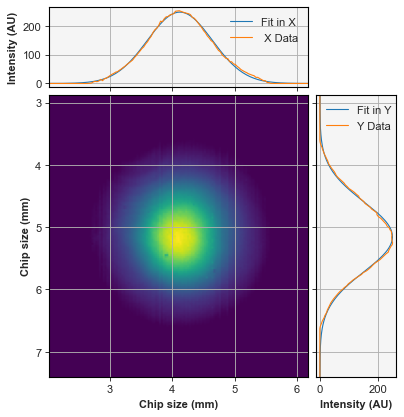

In [4]:
from BeamProcessor import BeamProcessor as bp
dir = r"C:\Users\keena\Downloads\20220711_collimation\Pos_9_rotate_right_20"

beam = bp(directory=dir, chipsize=[9.6, 7.68], wavelength=1550E-6)
beam.plotter.plot_fit(0, True)
